2.3. Predicting Price with Neighborhood

In [45]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import matplotlib.image as mpimg # to show images

warnings.simplefilter(action="ignore", category=FutureWarning)

In the last lesson, we created a model that used location — represented by latitude and longitude — to predict price. In this lesson, we're going to use a different representation for location: neighborhood.
##### Prepare Data
##### Import

In [32]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath,  encoding = "latin1")

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True) 

    # Extact neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace = True)

    return df

In the last lesson, we used our wrangle function to import two CSV files as DataFrames. But what if we had hundreds of CSV files to import? Wrangling them one-by-one wouldn't be an option. So let's start with a technique for reading several CSV files into a single DataFrame.

The first step is to gather the names of all the files we want to import. We can do this using pattern matching. 

Task 2.3.1: Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. Assign this list to the variable name files.

In [33]:
files = glob("datasets/buenos-aires-real-estate-*.csv")
files

['datasets\\buenos-aires-real-estate-1.csv',
 'datasets\\buenos-aires-real-estate-2.csv',
 'datasets\\buenos-aires-real-estate-3.csv',
 'datasets\\buenos-aires-real-estate-4.csv',
 'datasets\\buenos-aires-real-estate-5.csv']

In [34]:
# Check your work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

The next step is to read each of the CSVs in files into a DataFrame, and put all of those DataFrames into a list. What's a good way to iterate through files so we can do this? A for loop!

Task 2.3.2: Use your wrangle function in a for loop to create a list named frames. The list should the cleaned DataFrames created from the CSV filenames your collected in files.

In [35]:
frames = []

for file in files:
    df = wrangle(file)
    frames.append(df)

In [19]:
len(frames)

5

In [22]:
type(frames[0])

pandas.core.frame.DataFrame

In [17]:
frames[0].head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
29,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
40,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
41,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


In [36]:
# Check your work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

The final step is to use pandas to combine all the DataFrames in frames.

Task 2.3.3: Use pd.concat to concatenate the items in frames into a single DataFrame df. Make sure you set the ignore_index argument to True.

In [37]:
df = pd.concat(frames, ignore_index = True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [24]:
df.shape

(6582, 17)

In [38]:
# Check your work
assert len(df) == 6582, f"`df` is the wrong size: {len(df)}."

Excellent work! You can now clean and combine as many CSV files as your computer can handle. You're well on your way to working with big data. 📈
##### Explore
Looking through the output from the df.head() call above, there's a little bit more cleaning we need to do before we can work with the neighborhood information in this dataset. The good news is that, because we're using a wrangle function, we only need to change the function to re-clean all of our CSV files. This is why functions are so useful.

Task 2.3.4: Modify your wrangle function to create a new feature "neighborhood". You can find the neighborhood for each property in the "place_with_parent_names" column. For example, a property with the place name "|Argentina|Capital Federal|Palermo|" is located in the neighborhood is "Palermo". Also, your function should drop the "place_with_parent_names" column.

Be sure to rerun all the cells above before you continue.

In [27]:
df["place_with_parent_names"].str.split("|", expand=True)[3].head()

0       Chacarita
1      Villa Luro
2       Caballito
3    Constitución
4            Once
Name: 3, dtype: object

In [39]:
# Check your work
assert df.shape == (6582, 17), f"`df` is the wrong size: {df.shape}."
assert (
    "place_with_parent_names" not in df
), 'Remember to remove the `"place_with_parent_names"` column.'

In [31]:
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
3,sell,apartment,112000.0,USD,1698188.80,112000.0,NaN,60.0,NaN,1866.666667,1.0,2.0,NaN,http://belgrano.properati.com.ar/116pr_venta_d...,-34.564676,-58.455720,Belgrano
9,sell,apartment,76500.0,USD,1159923.60,76500.0,0.0,36.0,NaN,2125.000000,NaN,2.0,1000.0,http://caballito.properati.com.ar/12ksf_venta_...,-34.618830,-58.437779,Caballito
18,sell,apartment,90000.0,USD,1364616.00,90000.0,100.0,100.0,900.000000,900.000000,NaN,3.0,NaN,http://belgrano.properati.com.ar/zouu_venta_de...,-34.577168,-58.538654,Belgrano
20,sell,apartment,159900.0,USD,2424467.76,159900.0,82.0,77.0,1950.000000,2076.623377,NaN,3.0,NaN,http://colegiales.properati.com.ar/zpcd_venta_...,-34.571526,-58.455637,Colegiales
21,sell,apartment,123875.0,USD,1878242.30,123875.0,79.0,50.0,1568.037975,2477.500000,NaN,2.0,NaN,http://colegiales.properati.com.ar/12sbf_venta...,-34.578688,-58.457358,Colegiales


##### Split
At this point, you should feel more comfortable with the splitting data, so we're going to condense the whole process down to one task.

Task 2.3.5: Create your feature matrix X_train and target vector y_train. X_train should contain one feature: "neighborhood". Your target is "price_aprox_usd".

In [40]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [41]:
# Check your work
assert X_train.shape == (6582, 1), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

##### Build Model
##### Baseline
Let's also condense the code we use to establish our baseline.

Task 2.3.6: Calculate the baseline mean absolute error for your model.

In [42]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


The mean apartment price and baseline MAE should be similar but not identical to last lesson. The numbers will change since we're working with more data.

##### Iterate
If you try to fit a LinearRegression predictor to your training data at this point, you'll get an error that looks like this:

    ValueError: could not convert string to float
What does this mean? When you fit a linear regression model, you're asking scikit-learn to perform a mathematical operation. The problem is that our training set contains neighborhood information in non-numerical form. In order to create our model we need to encode that information so that it's represented numerically. The good news is that there are lots of transformers that can do this. Here, we'll use the one from the Category Encoders library, called a OneHotEncoder.

Before we build include this transformer in our pipeline, let's explore how it works.

Task 2.3.7: First, instantiate a OneHotEncoder named ohe. Make sure to set the use_cat_names argument to True. Next, fit your transformer to the feature matrix X_train. Finally, use your encoder to transform the feature matrix X_train, and assign the transformed data to the variable XT_train.

In [43]:
X_train.head()

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constitución
4,Once


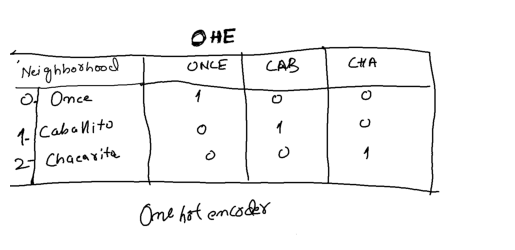

In [46]:
# Load the image
img = mpimg.imread("C:/Users/Yahya/Desktop/My folder/Programming/Python/WQU_DS_lab/housing_in_Buenos_Aires/images/image 3.png")

# Display the image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()

In [50]:
"""
What is One-Hot Encoding?
One-hot encoding converts categorical variables into a binary matrix (a format that consists of 0s and 1s). Each unique category in the data is represented as a binary vector with only one high bit (1) and the rest low bits (0).

For example, given a categorical column like:

Color
-----
Red
Blue
Green


One-hot encoding transforms it into:

Red  Blue  Green
 1     0     0
 0     1     0
 0     0     1
""";

<!-- What is One-Hot Encoding?

One-hot encoding converts categorical variables into a binary matrix (a format that consists of 0s and 1s). Each unique category in the data is represented as a binary vector with only one high bit (1) and the rest low bits (0).

For example, given a categorical column like:

Color
-----
Red

Blue

Green

One-hot encoding transforms it into:

Red  Blue  Green

 1     0     0

 0     1     0

 0     0     1 -->


In [51]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)
# Fit
ohe.fit(X_train)
# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Check your work
assert XT_train.shape == (6582, 57), f"`XT_train` is the wrong shape: {XT_train.shape}"

Now that we have an idea for how the OneHotEncoder works, let's bring it into our pipeline.

Task 2.3.8: Create a pipeline named model that contains a OneHotEncoder transformer and a LinearRegression predictor. Then fit your model to the training data.

In [67]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train) # fit the model

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [54]:
# Check your work
check_is_fitted(model[-1])

Wow, you just built a model with two transformers and a predictor! When you started this course, did you think you'd be able to do something like that? 😁

##### Evaluate
Regardless of how you build your model, the evaluation step stays the same. Let's see how our model performs with the training set.

Task 2.3.9: First, create a list of predictions for the observations in your feature matrix X_train. Name this list y_pred_training. Then calculate the training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.

In [68]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


Now let's check our test performance.

Task 2.3.10: Run the code below to import your test data buenos-aires-test-features.csv into a DataFrame and generate a Series of predictions using your model. Then run the following cell to submit your predictions to the grader.

In [69]:
X_test = pd.read_csv("datasets/buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

Communicate Results

If we write out the equation for our model, it'll be too big to fit on the screen. That's because, when we used the OneHotEncoder to encode the neighborhood data, we created a much wider DataFrame, and each column/feature has it's own coefficient in our model's equation.

Equation: y = β0 + β1 x1 + β2 x2 + ... + β59 x59 + β60 x60 

y = price

β0 = intercept

β1 = coefficient 1

x1 = neighborhood Villa Crespo

β2 = coefficient 2

x2 = neighborhood Chacarita

β59 = coefficient 59

x59 = neighborhood Catalinas

β60 = coefficient 60

x60 = Villa Real

This is important to keep in mind for two reasons. First, it means that this is a high-dimensional model. Instead of a 2D or 3D plot, we'd need a 58-dimensional plot to represent it, which is impossible! Second, it means that we'll need to extract and represent the information for our equation a little differently than before. Let's start by getting our intercept and coefficient.

Task 2.3.11: Extract the intercept and coefficients for your model.

In [70]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[-2.89895934e+03 -6.29555350e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


In [58]:
# Check your work
assert isinstance(
    intercept, float
), f"`intercept` should be a `float`, not {type(intercept)}."
assert isinstance(
    coefficients, np.ndarray
), f"`coefficients` should be a `float`, not {type(coefficients)}."
assert coefficients.shape == (
    57,
), f"`coefficients` is wrong shape: {coefficients.shape}."

We have the values of our coefficients, but how do we know which features they belong to? We'll need to get that information by going into the part of our pipeline that did the encoding.

Task 2.3.12: Extract the feature names of your encoded data from the OneHotEncoder in your model.

In [71]:
feature_names = model.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita' 'neighborhood_Villa Luro'
 'neighborhood_Caballito' 'neighborhood_Constitución' 'neighborhood_Once']


In [61]:
# Check your work
assert isinstance(
    feature_names, np.ndarray
), f"`features` should be a `list`, not {type(feature_names)}."
assert len(feature_names) == len(
    coefficients
), "You should have the same number of features and coefficients."

We have coefficients and feature names, and now we need to put them together. For that, we'll use a Series.

Task 2.3.13: Create a pandas Series named feat_imp where the index is your features and the values are your coefficients.

In [72]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constitución   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

In [63]:
# Check your work
assert isinstance(
    feat_imp, pd.Series
), f"`feat_imp` should be a `float`, not {type(feat_imp)}."
assert feat_imp.shape == (57,), f"`feat_imp` is wrong shape: {feat_imp.shape}."
assert all(
    a == b for a, b in zip(sorted(feature_names), sorted(feat_imp.index))
), "The index of `feat_imp` should be identical to `features`."

To be clear, it's definitely not a good idea to show this long equation to an audience, but let's print it out just to check our work. Since there are so many terms to print, we'll use a for loop.

Task 2.3.14: Run the cell below to print the equation that your model has determined for predicting apartment price based on longitude and latitude.

In [73]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-2898.96 * neighborhood_Chacarita)
+ (-6.3 * neighborhood_Villa Luro)
+ (9252.89 * neighborhood_Caballito)
+ (-41748.73 * neighborhood_Constitución)
+ (-3230.37 * neighborhood_Once)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-8662.28 * neighborhood_Flores)
+ (46954.21 * neighborhood_Belgrano)
+ (-13729.1 * neighborhood_Liniers)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-10678.63 * neighborhood_San Cristobal)
+ (-7974.66 * neighborhood_Congreso)
+ (14701.16 * neighborhood_Saavedra)
+ (-11172.55 * neighborhood_Balvanera)
+ (-29585.61 * neighborhood_Parque Avellaneda)
+ (72740.78 * neighborhood_Recoleta)
+ (5638.47 * neighborhood_San Telmo)
+ (42831.32 * neighborhood_Nuñez)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-6323.68 * neighborhood_Parque Centenario)
+ (4330.55 * neighborhood_Abasto)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-19370.74 * neighborhood_)
+ (-7108.23 * neighborhood_Paternal)
+ (-21078.78 * neighborhood_Ma

Task 2.3.15: Scroll up, change the predictor in your model to Ridge, and retrain it. Then evaluate the model's training and test performance. Do you still have an overfitting problem? If not, extract the intercept and coefficients again (you'll need to change your code a little bit) and regenerate the model's equation. Does it look different than before?

In [74]:
# Check your work
assert isinstance(
    model[-1], Ridge
), "Did you retrain your model using a `Ridge` predictor?"

We're back on track with our model, so let's create a visualization that will help a non-technical audience understand what the most important features for our model in predicting apartment price.

Task 2.3.16: Create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.

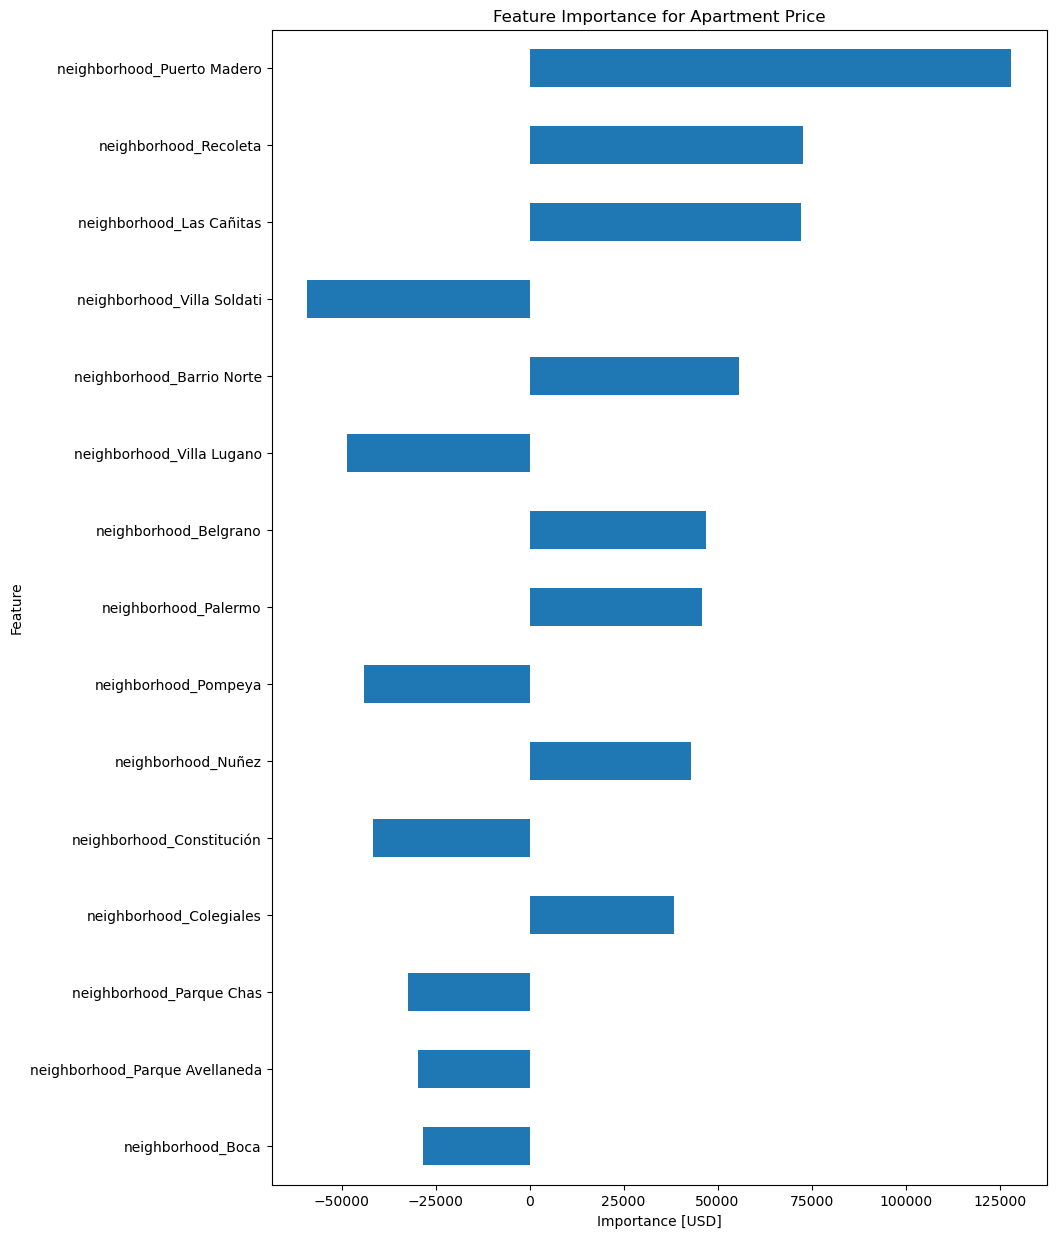

In [78]:
feat_imp.sort_values(key = abs).tail(15).plot(kind="barh", figsize=(10, 15))
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");